<a href="https://colab.research.google.com/github/marabian/toxic-comment-classification/blob/master/toxic-comment-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Toxic Comment Classification
***

[Link to Kaggle challenge/dataset](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/)


In [1]:
import os
import random as rnd

# data analysis and wrangling
import pandas as pd
import numpy as np


# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
# to mount google drive for colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# check gpu support
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# check if gpu working
# tf.test.gpu_device_name()

In [ ]:
# change notebook theme
#!jt -t monokai -T -N -kl

## Workflow


* Defining the problem and assembling a dataset<br>


* Choosing a measure of success


* Deciding on an evaluation protocol


* Preparing your data for ML algorithms


* Developing a model that does better than a baseline


* Scaling up: developing a model that overfits


* Regularizing your model and tuning your hyperparameters



## Defining the problem and assembling a dataset
***


We are challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate. Our training data will consist of ~160,000 comments from Wikipedia’s talk page edits with labeled levels of toxicity. Detecting toxic comments online will hopefully help online discussion become more productive and respectful.<br>

Since we have many classes, this problem is an instance of multiclass classification; and because each data point could belong to multiple categories (in this case, levels of toxicity), this is a **multilabel, multiclass classification problem**.

We will start with a solving a subset of this problem, using **binary classification** to classify between "good" and "toxic" comments.

In [8]:
path_to_data = "/content/drive/My Drive/machine learning/notebooks/data/jigsaw-toxic-comment-classification-challenge/"

In [15]:
train_df = pd.read_csv(path_to_data + "train.csv")
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_df



,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


Let's build a new dataframe containing just the training examples for our binary classification problem.

In [32]:
bin_df = pd.concat([
           train_df[train_df[labels].eq(0).all(1)][['id', 'comment_text', 'toxic']], # get new df with rows for "good" comments
           train_df[train_df['toxic'] == 1][['id', 'comment_text', 'toxic']]] # get new dataframe with rows for "toxic" comments
         ).reset_index(drop=True)

In [33]:
bin_df

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
158635,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1
158636,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1
158637,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1
158638,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1


**Plot distribution of toxic comment frequency**

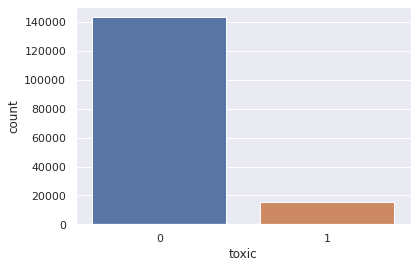

In [35]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="toxic", data=bin_df)

In [36]:
print(bin_df['toxic'].value_counts())

0    143346
1     15294
Name: toxic, dtype: int64


As we can see, our classes are heavily imbalanced. There are a lot more "good" comments than "toxic". To deal with this class imbalance problem, we will choose ***precision and recall*** as our **evaluation metric**. This will be our measure of success.

## Preparing the raw text data
***

Let's start doing some text preprocessing! In NLP, the main steps to preprocess raw text into tensors includes the following steps:<br> ***word tokenization***, ***text cleaning*** (lowercasing, removing stop words and punctuation, stemming), and ***text vectorization***.

Our first *vectorization scheme* will be using **TF-IDF vectors** for the  most common words found in our corpus.

In information retrieval, **TF-IDF**, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. We will use *Scikit-Learn's* awesome **TfidfVectorizer** to convert a collection of raw documents to a matrix of TF-IDF features. This does all the text preprocessing steps we need.

### Bulding feature vectors using TF-IDF

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase='True', stop_words='english', max_features=10)
X = vectorizer.fit_transform(bin_df.comment_text)

print(vectorizer.get_feature_names())
print(X.shape)

['actually', 'add', 'added', 'article', 'articles', 'ask', 'believe', 'best', 'better', 'block', 'blocked', 'case', 'change', 'com', 'comment', 'comments', 'content', 'deleted', 'deletion', 'did', 'didn', 'discussion', 'does', 'doesn', 'don', 'edit', 'editing', 'editors', 'edits', 'fact', 'feel', 'free', 'fuck', 'going', 'good', 'help', 'hi', 'history', 'hope', 'http', 'image', 'information', 'just', 'know', 'let', 'like', 'link', 'links', 'list', 'll', 'look', 'make', 'need', 'new', 'note', 'page', 'pages', 'people', 'person', 'personal', 'place', 'point', 'policy', 'question', 'questions', 'read', 'really', 'reason', 'removed', 'right', 'said', 'say', 'section', 'source', 'sources', 'stop', 'subject', 'sure', 'talk', 'thank', 'thanks', 'thing', 'things', 'think', 'time', 'use', 'used', 'user', 'using', 'utc', 'vandalism', 've', 'want', 'way', 'welcome', 'wiki', 'wikipedia', 'work', 'wp', 'wrong']
(158640, 100)


In order to get a better idea on how many words to consider as features, let's visualize the distribution of word counts amongst our training examples. In order to do this, we must first preprocess the raw text data ourselves. Let's define a function to preprocess the comments by *tokenizing* and *cleaning*.

In [90]:
import re
import string
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# stemmer
stemmer = PorterStemmer()

# stop words
nltk.download('stopwords')
nltk.download('punkt')
stopwords_english = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [91]:
def process_comment(comment):
    """Process comment function.
    Input:
        comment: a string containing a comment
    Output:
        comment_clean: a list of cleaned word tokens

    """

    # normalizing case
    comment = comment.lower()

    # remove special characters
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    comment = re.sub(pat, '', comment)

    # remove numbers
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    comment = re.sub(pattern, '', comment)

    # remove punctuation
    comment = comment.translate(str.maketrans('', '', string.punctuation))

    # replace repeated character sequences of length 3 or greater with sequences of length 3
    comment = nltk.tokenize.casual.reduce_lengthening(comment)
    
    # tokenize comment
    tokens = word_tokenize(comment)
    
    # remove stop words and stem
    #comment_clean = [stemmer.stem(token) for token in tokens if token not in stopwords_english]
    comment_clean = [token for token in tokens if token not in stopwords_english]

    return tokens

In [93]:
vectorizer = TfidfVectorizer(tokenizer=process_comment, max_features=10)
X = vectorizer.fit_transform(bin_df.comment_text)

print(vectorizer.get_feature_names())
print(X.shape)

KeyboardInterrupt: ignored

['aaammm', 'doesnt', 'decor', 'happi']

In [62]:
nltk.tokenize.casual.reduce_lengthening("I AAAAAAAAAAM 23 doesn't decoration")

"I AAAM 23 doesn't decoration"